# Build Target Model

Here we expand our on target rules to include information about the target site.
We consider four feature classes when building this model:

1. Position within a gene, including sgRNA oriention
2. Protein Domain information: whether a guide targets within an annotated protein domain
3. Sequence conservation
4. Amino acid idenity and physiochemical properties


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import joblib
import seaborn as sns
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from scipy import stats
import optuna
from joblib import Parallel, delayed
from datetime import datetime
import numpy as np
import gpplot

import target_featurization as ft
from core import (get_predictive_performance,
                  setup_plots,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  get_tidy_cv_df,
                  get_feature_df,
                  get_performance_type_df,
                  plot_performance_type_df)
from datasets import dataset_list, get_sg_groups_df

In [2]:
setup_plots()

In [3]:
def get_fold_predictions(fold, fold_df, model_name, features,
                         aa_seq_df,
                         protein_domain_df,
                         conservation_df,
                         base_model=Pipeline([('imputer', SimpleImputer(strategy='median')),
                                              ('regressor', LGBMRegressor(random_state=7, n_jobs=8))]),
                         aa_width=16, aa_features=None,
                         cons_small_width=4, cons_large_width=32):
    """Get predictions for a given fold

    :param fold: int
    :param fold_df: DataFrame
    :param model_name: str
    :param features: list
    :param aa_seq_df: DataFrame, fed into target featurization
    :param protein_domain_df: DataFrame, fed into target featurization
    :param conservation_df: DataFrame, fed into target featurization
    :param base_model: Pipeline(Imputer, Regressor)
    :param aa_width: int
    :param aa_features: list or None, see featurize_aa_seqs for options. Will default to best options if None
    :param cons_small_width: int
    :param cons_large_width: int
    :return: DataFrame, test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                      aa_features=aa_features,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    X_train = train_feature_df[train_feature_cols]
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                    aa_features=aa_features,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    X_test = test_feature_df[test_feature_cols]
    model = clone(base_model)
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_model: Pipeline (Imputer, Regressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for Pipeline

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index, features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

In [5]:
id_cols = ['sgRNA Context Sequence', 'Target Cut Length', 'Target Transcript', 'Orientation']

## Loading Datasets

In [6]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)

Context sequences with multiple targets: 0


## Protein Domain Features

In [7]:
domain_model_matrix = ft.get_protein_domain_features(sg_groups_df, protein_domains, sources=None,
                                                     id_cols=id_cols)

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


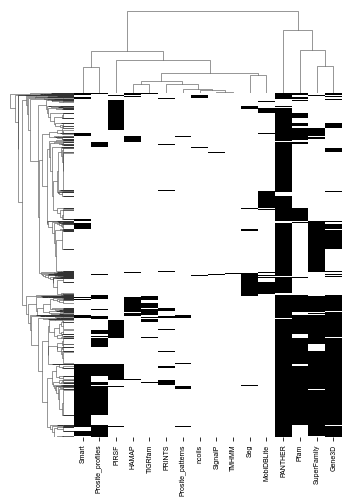

In [8]:
g = sns.clustermap(domain_model_matrix.set_index(id_cols),
                   cmap='binary', cbar_pos=None, metric='hamming',
                   yticklabels=False, figsize=(5, 7))
g.ax_heatmap.set_ylabel("")
gpplot.savefig('../figures/domain_clustermap.pdf')

In [9]:
long_domain_model_matrix = domain_model_matrix.melt(id_vars=id_cols,
                                                    var_name='source',
                                                    value_name='present')
long_domain_model_matrix = long_domain_model_matrix[long_domain_model_matrix['present'] == 1]
(long_domain_model_matrix[['Target Transcript', 'source']].value_counts()
 .reset_index()['source'].value_counts())

PANTHER             122
Pfam                118
Gene3D              115
SuperFamily         108
Seg                  92
Smart                76
Prosite_profiles     69
Prosite_patterns     67
MobiDBLite           65
PRINTS               35
ncoils               31
PIRSF                28
HAMAP                16
TIGRfam              14
TMHMM                10
SignalP               8
Name: source, dtype: int64

## Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [10]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

In [11]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = (conservation_aa_i['target position'] - 1) // 3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                on='Transcript Base'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

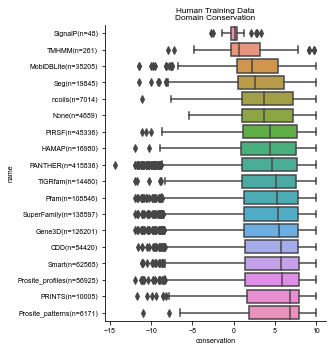

In [12]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box', height=4.5)
plt.title('Human Training Data\nDomain Conservation')
gpplot.savefig('../figures/human_domain_conservation.pdf')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

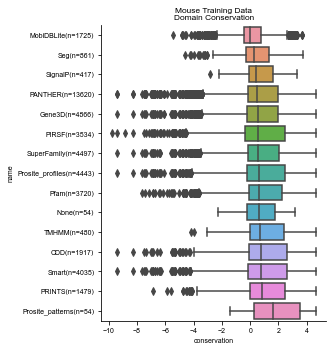

In [13]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box', height=4.5)
plt.title('Mouse Training Data\nDomain Conservation')

## Calculating Residuals

In [14]:
sg_df_residuals = sg_groups_df.copy()
seq_X = get_feature_df(sg_df_residuals)
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7808375117208222, 4.324227242326856e-205)
Doench2014_mouse     (0.7404292413640493, 1.379605215185353e-203)
Doench2016                              (0.6937302010352973, 0.0)
Munoz2016                               (0.7588083762083931, 0.0)
Wang2014            (0.7817756947398344, 1.9046619919131385e-211)
dtype: object

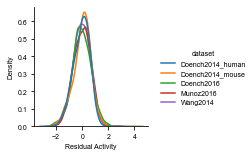

In [15]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False, height=2.2)
gpplot.savefig('../figures/model_residuals.pdf')

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [16]:
tidy_cv_df = get_tidy_cv_df(sg_df_residuals, random_state=1)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
23,2,Doench2014_human,1
22,2,Doench2014_mouse,1
24,4,Doench2014_human,1
0,0,Doench2014_human,2
1,0,Doench2014_mouse,2
20,0,Doench2016,2
19,0,Munoz2016,2
18,0,Wang2014,2
17,1,Doench2014_human,2
16,1,Doench2014_mouse,2


- Training sizes vary from 18,677 - 22,586 sgRNAs
- Testing sizes vary from 4,272 - 8,181 sgRNAs

In [17]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,4272
0,0,True,22586
5,1,False,8181
4,1,True,18677
8,2,False,4372
1,2,True,22486
6,3,False,5544
3,3,True,21314
7,4,False,4489
2,4,True,22369


As expected each gene target (gene) only appears in one set in each fold

In [18]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 [['cv', 'target']].value_counts()  # will show up twice if train == False and True
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Feature Sets

### Amino Acid Width

In [19]:
aa_width_prediction_list = []
aa_widths = [2, 4, 8, 16, 32]
for width in aa_widths:
    print(width)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='aa ' + str(width),
                                           features=['aa'],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df,
                                           aa_width=width, aa_features=None)
        aa_width_prediction_list.append(predictions)
    print('\n')

aa_width_predictive_performance, aa_width_agg_performance = get_predictive_performance(aa_width_prediction_list,
                                                                                       'Residual Activity')

2
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


8
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




We'll use a width of 16 as our default for Amino Acid featurization

In [20]:
aa_width_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,aa 16,0.186075,0.147755,0.198058
1,aa 8,0.178726,0.133223,0.208053
2,aa 32,0.172723,0.135843,0.180469
3,aa 4,0.147685,0.093290,0.164908
4,aa 2,0.096954,0.114068,0.104131


In [21]:
import plotnine as gg
font='Arial'; font_size=7; title_size=8.2
gg.theme_set(gg.theme_classic() +
                 gg.theme(text=gg.element_text(family=font, size=font_size),
                          plot_title=gg.element_text(family=font, size=title_size),
                          axis_text=gg.element_text(color='black'),
                          strip_background=gg.element_blank(),
                          plot_background=gg.element_blank()))

Saving 2.5 x 2.5 in image.
Filename: ../figures/target_aa_performance_heatmap.pdf


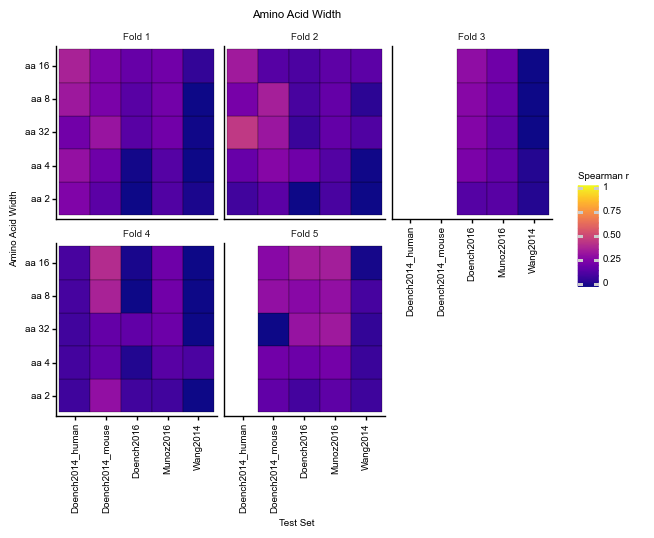

<ggplot: (8776607314640)>

In [22]:
g = plot_spearman_heatmap(aa_width_predictive_performance, title='Amino Acid Width', ylabel='Amino Acid Width')
g.save('../figures/target_aa_performance_heatmap.pdf', width=2.5, height=2.5)
g

Saving 3 x 3 in image.
Filename: ../figures/target_model_aa_width.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may 

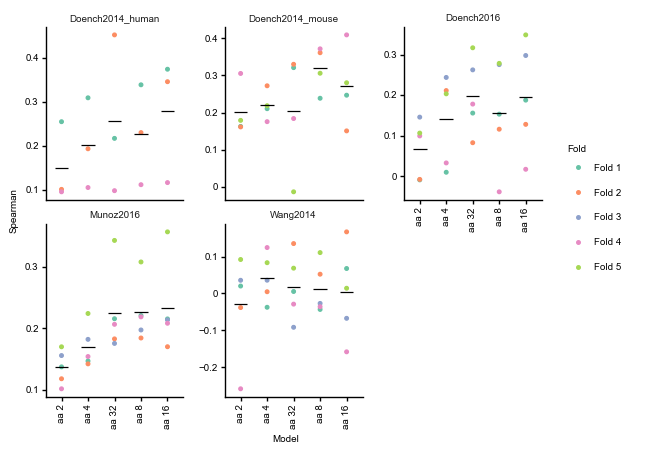

<ggplot: (8776935585341)>

In [23]:
g = plot_model_performance(aa_width_predictive_performance)
g.save('../figures/target_model_aa_width.pdf', width=3, height=3)
g

### Conservation Width

In [24]:
cons_width_prediction_list = []
cons_small_widths = [2, 4, 8]
cons_large_widths = [16, 32, 64]
for small_width in cons_small_widths:
    print('Small: ' + str(small_width))
    for large_width in cons_large_widths:
        print('Large: ' + str(large_width))
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold, df, model_name='cons ' + str(small_width) +  ', ' +
                                                                    str(large_width),
                                               features=['conservation'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               cons_small_width=small_width,
                                               cons_large_width=large_width)
            cons_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

cons_width_predictive_performance, cons_width_agg_performance = get_predictive_performance(cons_width_prediction_list,
                                                                                           'Residual Activity')

Small: 2
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 4
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 8
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






It looks like a small width of 4 and a large width of 32 is optimal for conservation

In [25]:
cons_width_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,"cons 4, 32",0.109353,0.157461,0.124099
1,"cons 8, 16",0.108433,0.136532,0.088330
2,"cons 8, 32",0.100428,0.155942,0.057372
3,"cons 8, 64",0.097854,0.150466,0.081314
4,"cons 4, 16",0.095250,0.160747,0.081347
5,"cons 2, 16",0.089690,0.167821,0.092646
6,"cons 2, 32",0.086444,0.175432,0.079726
7,"cons 4, 64",0.077590,0.177568,0.066384
8,"cons 2, 64",0.075342,0.180968,0.071444


Saving 2.5 x 2.5 in image.
Filename: ../figures/target_model_cons_width.pdf


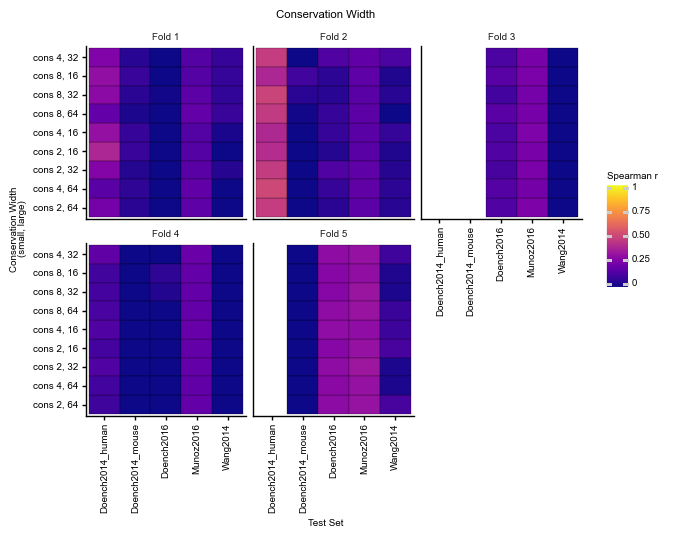

<ggplot: (8776936630309)>

In [26]:
g = plot_spearman_heatmap(cons_width_predictive_performance,
                          title='Conservation Width', ylabel='Conservation Width\n(small, large)')
g.save('../figures/target_model_cons_width.pdf', width=2.5, height=2.5)
g

Saving 4 x 3 in image.
Filename: ../figures/target_model_cons_width.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000f

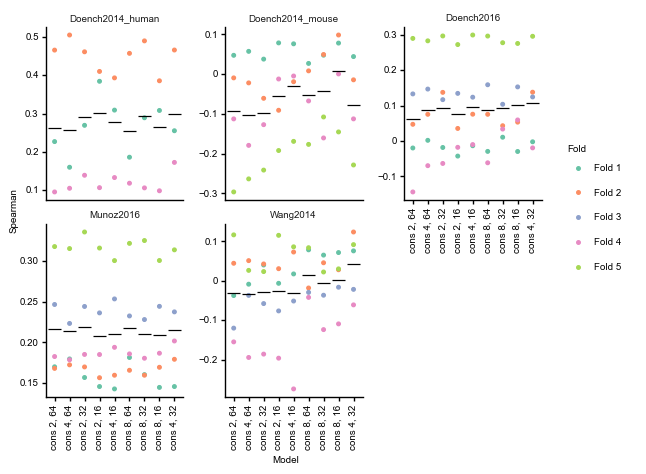

<ggplot: (8776601138601)>

In [27]:
g = plot_model_performance(cons_width_predictive_performance)
g.save('../figures/target_model_cons_width.pdf', width=4, height=3)
g

### Single Feature Sets

In [28]:
single_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name=feature,
                                           features=[feature],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        single_prediction_list.append(predictions)
    print('\n')

single_predictive_performance, single_agg_performance = get_predictive_performance(single_prediction_list,
                                                                                   'Residual Activity')


position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




All features are able to positively predict the residual activity of sgRNAs

In [29]:
single_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,domain,0.194020,0.174449,0.184055
1,aa,0.186075,0.147755,0.198058
2,conservation,0.109353,0.157461,0.124099
3,position,0.078879,0.078426,0.066053


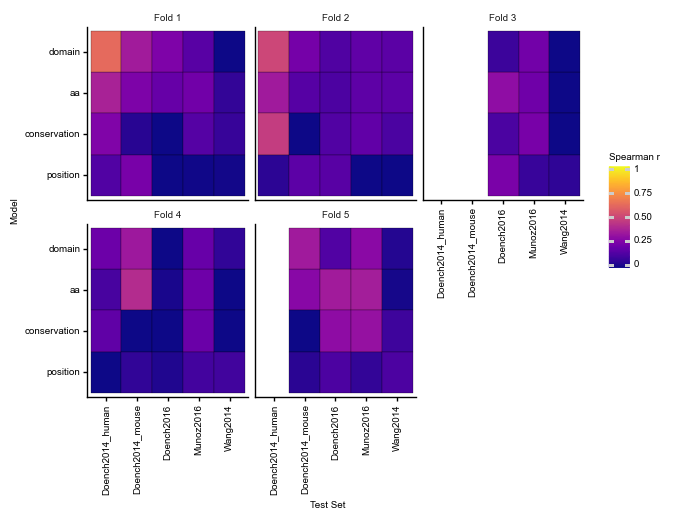

<ggplot: (8776935539601)>

In [30]:
plot_spearman_heatmap(single_predictive_performance)

Saving 2.7 x 2.7 in image.
Filename: ../figures/target_model_single_performance.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edg

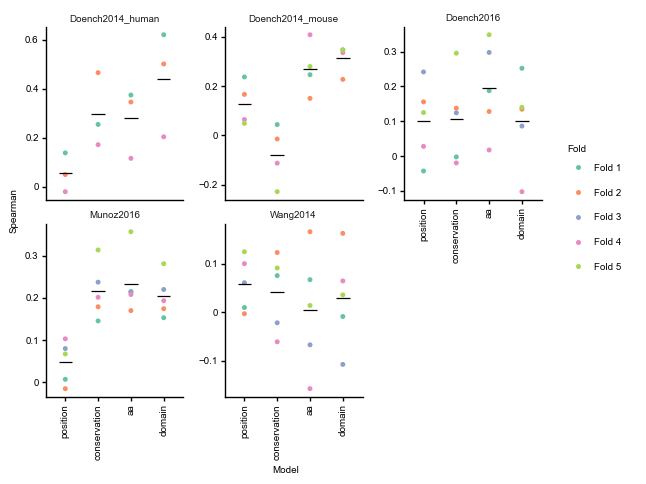

<ggplot: (8776533343440)>

In [31]:
g = plot_model_performance(single_predictive_performance)
g.save('../figures/target_model_single_performance.pdf', width=2.7, height=2.7)
g

### Complete Feature Set

All features together are better than any one alone.

In [32]:
complete_feature_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='All features',
                                       features=features,
                                       aa_seq_df=aa_seqs,
                                       protein_domain_df=protein_domains,
                                       conservation_df=conservation_df)
    complete_feature_list.append(predictions)

complete_predictive_performance, complete_agg_performance = get_predictive_performance(complete_feature_list +
                                                                                       single_prediction_list,
                                                                                       'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [33]:
complete_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All features,0.243202,0.146578,0.266182
1,domain,0.194020,0.174449,0.184055
2,aa,0.186075,0.147755,0.198058
3,conservation,0.109353,0.157461,0.124099
4,position,0.078879,0.078426,0.066053


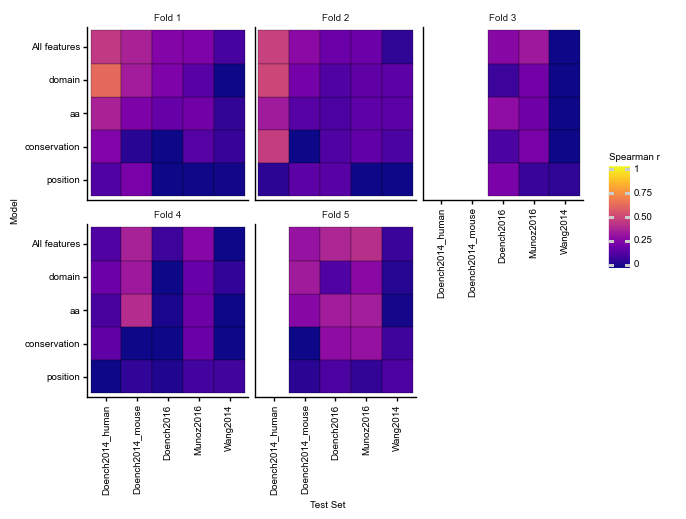

<ggplot: (8776942276783)>

In [34]:
plot_spearman_heatmap(complete_predictive_performance)

Saving 3 x 3 in image.
Filename: ../figures/target_all_performance.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may

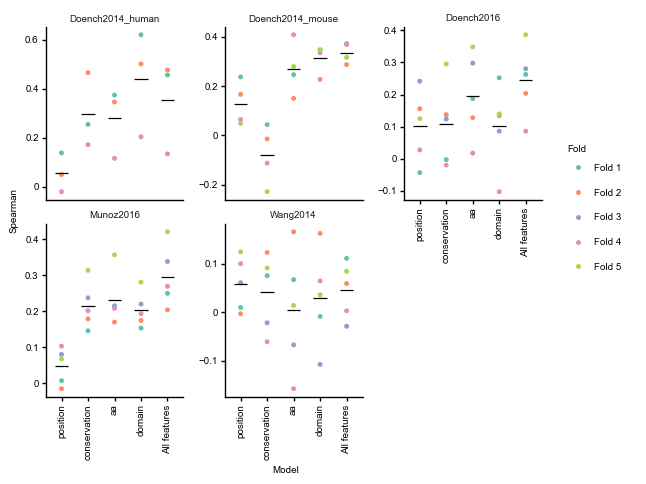

<ggplot: (8776688084315)>

In [35]:
g = plot_model_performance(complete_predictive_performance)
g.save('../figures/target_all_performance.pdf', width=3, height=3)
g

### Leave One Set Out

We can remove conservation features and maintain near-optimal results

In [36]:
leave_one_prediction_list = []
for feature in features:
    print(feature)
    curr_features = features.copy()
    curr_features.remove(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='No ' + feature,
                                           features=curr_features,
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        leave_one_prediction_list.append(predictions)
    print('\n')

leave_one_predictive_performance, leave_one_agg_performance = get_predictive_performance(
    leave_one_prediction_list + complete_feature_list, 'Residual Activity')

position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




In [37]:
leave_one_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All features,0.243202,0.146578,0.266182
1,No conservation,0.243106,0.129201,0.246775
2,No position,0.242326,0.160562,0.270829
3,No aa,0.220374,0.172575,0.202254
4,No domain,0.207319,0.160478,0.193439


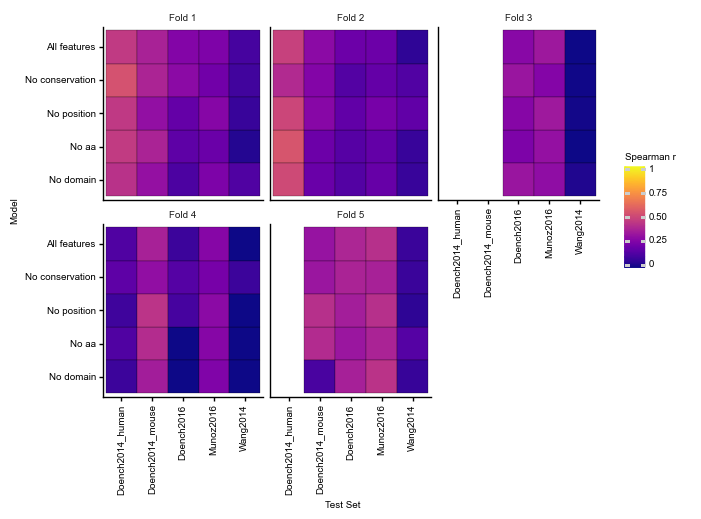

<ggplot: (8776602943404)>

In [38]:
plot_spearman_heatmap(leave_one_predictive_performance)

You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff',

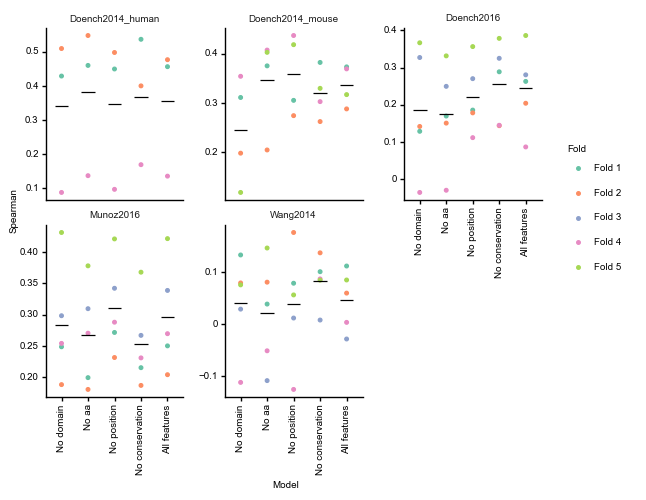

<ggplot: (8776602950810)>

In [39]:
plot_model_performance(leave_one_predictive_performance)

## Hyperparameter Tuning

We'll use optuna to tune hyperparameters for the model

In [40]:
n_trials = 50
model_name = 'All features +\nhyperparameter tuning'
final_features = features.copy()

In [41]:
tpe_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data, features=final_features,
                                   aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                                   conservation_df=conservation_df)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=final_features,
                                                                      aa_seq_df=aa_seqs,
                                                                      protein_domain_df=protein_domains,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                      ('regressor',
                       LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                                     **trial.params))])
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=1000)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(fold_test_data,
                                                                    features=final_features,
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = model_name
    test_predictions['fold'] = fold
    tpe_prediction_list.append(test_predictions)


[I 2021-08-06 16:02:25,988] A new study created in memory with name: no-name-743f9067-09d9-4bb5-86e7-11c6d0320d31


Fold: 0


[I 2021-08-06 16:02:48,274] Trial 0 finished with value: 0.06201329977330232 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.06201329977330232.
[I 2021-08-06 16:03:08,257] Trial 1 finished with value: 0.0474249527374371 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.06201329977330232.
[I 2021-08-06 16:03:27,075] Trial 2 finished with value: 0.0504847974103807 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.06201329977330232.
[I 2021-08-06 16:03:44,507] Trial 3 finished with value: 0.05430555103372044 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.06201329977330232.
[I 2021-08-06 16:04:03,908] Trial 4 finished with value: 0.047640559051435605 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.06201329977330232.
[I 2021-08-06 16:04:24,260] Trial 5 finished with value: 0.

Number of finished trials: 50
Training Time: 0:15:15.073636
Best trial:
  Value: 0.080127033052463
  Params: 
    num_leaves: 8
    min_child_samples: 53
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.427106
[2000]	valid_0's l2: 0.42058
Early stopping, best iteration is:
[2425]	valid_0's l2: 0.41828


[I 2021-08-06 16:17:50,727] A new study created in memory with name: no-name-c3397ff2-c09b-423d-b08a-91615be21f61


Fold: 1


[I 2021-08-06 16:18:02,012] Trial 0 finished with value: 0.10563073280447617 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.10563073280447617.
[I 2021-08-06 16:18:17,096] Trial 1 finished with value: 0.08929757881636555 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.10563073280447617.
[I 2021-08-06 16:18:32,980] Trial 2 finished with value: 0.08608317945096575 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.10563073280447617.
[I 2021-08-06 16:18:47,540] Trial 3 finished with value: 0.09491641521754875 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.10563073280447617.
[I 2021-08-06 16:19:03,499] Trial 4 finished with value: 0.08874080510797247 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.10563073280447617.
[I 2021-08-06 16:19:20,611] Trial 5 finished with value: 0

Number of finished trials: 50
Training Time: 0:12:20.976295
Best trial:
  Value: 0.11471067121342152
  Params: 
    num_leaves: 8
    min_child_samples: 53
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.392272
Early stopping, best iteration is:
[1119]	valid_0's l2: 0.391504


[I 2021-08-06 16:30:21,668] A new study created in memory with name: no-name-ad832991-c6f9-4be0-aac4-23b7c0159c43


Fold: 2


[I 2021-08-06 16:30:37,519] Trial 0 finished with value: 0.07396143823985395 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.07396143823985395.
[I 2021-08-06 16:30:56,877] Trial 1 finished with value: 0.06532503835817578 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.07396143823985395.
[I 2021-08-06 16:31:17,577] Trial 2 finished with value: 0.05752381262927482 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.07396143823985395.
[I 2021-08-06 16:31:37,486] Trial 3 finished with value: 0.060907749824587 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.07396143823985395.
[I 2021-08-06 16:31:57,711] Trial 4 finished with value: 0.0575234374342581 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.07396143823985395.
[I 2021-08-06 16:32:17,014] Trial 5 finished with value: 0.06

Number of finished trials: 50
Training Time: 0:15:36.840894
Best trial:
  Value: 0.08494985059575091
  Params: 
    num_leaves: 10
    min_child_samples: 183
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.389865
Early stopping, best iteration is:
[1614]	valid_0's l2: 0.386206


[I 2021-08-06 16:46:08,666] A new study created in memory with name: no-name-417cf3f1-1661-4739-a240-4450865e21a6


Fold: 3


[I 2021-08-06 16:46:24,425] Trial 0 finished with value: 0.06683313801277113 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.06683313801277113.
[I 2021-08-06 16:46:45,000] Trial 1 finished with value: 0.05605545369476459 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.06683313801277113.
[I 2021-08-06 16:47:03,883] Trial 2 finished with value: 0.050642027212484966 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.06683313801277113.
[I 2021-08-06 16:47:20,762] Trial 3 finished with value: 0.062140030613353714 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.06683313801277113.
[I 2021-08-06 16:47:37,420] Trial 4 finished with value: 0.052070320531130455 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.06683313801277113.
[I 2021-08-06 16:47:57,198] Trial 5 finished with value

Number of finished trials: 50
Training Time: 0:14:41.967047
Best trial:
  Value: 0.08613011648238542
  Params: 
    num_leaves: 8
    min_child_samples: 130
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.395991
[2000]	valid_0's l2: 0.388099
Early stopping, best iteration is:
[2202]	valid_0's l2: 0.386732


[I 2021-08-06 17:01:01,568] A new study created in memory with name: no-name-3aab74d8-c68b-4d5c-b9e6-ecc95f593df2


Fold: 4


[I 2021-08-06 17:01:24,008] Trial 0 finished with value: 0.04785834745385307 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.04785834745385307.
[I 2021-08-06 17:01:47,073] Trial 1 finished with value: 0.0368374480742039 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.04785834745385307.
[I 2021-08-06 17:02:08,402] Trial 2 finished with value: 0.0400490189628558 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.04785834745385307.
[I 2021-08-06 17:02:29,882] Trial 3 finished with value: 0.047548217405300616 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.04785834745385307.
[I 2021-08-06 17:02:57,273] Trial 4 finished with value: 0.041187516893787704 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.04785834745385307.
[I 2021-08-06 17:03:19,124] Trial 5 finished with value: 0

Number of finished trials: 50
Training Time: 0:16:44.054461
Best trial:
  Value: 0.06637294593981816
  Params: 
    num_leaves: 8
    min_child_samples: 255
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.396192
Early stopping, best iteration is:
[1491]	valid_0's l2: 0.392851


Tuning hyperparameters improves performance quite a bit

In [42]:
top_features = [df for df in leave_one_prediction_list if (df['model_name'] == 'All features').all()]
tpe_predictive_performance, tpe_agg_performance = get_predictive_performance(
    top_features + tpe_prediction_list, 'Residual Activity')

In [43]:
tpe_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All features +\nhyperparameter tuning,0.249248,0.177982,0.24849


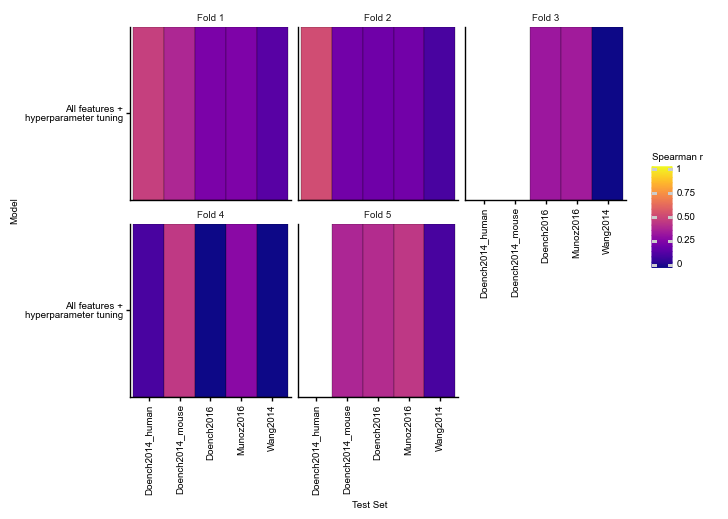

<ggplot: (8776534842796)>

In [44]:
plot_spearman_heatmap(tpe_predictive_performance)

Saving 2.5 x 2.5 in image.
Filename: ../figures/target_model_tpe_performance.pdf
You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in t

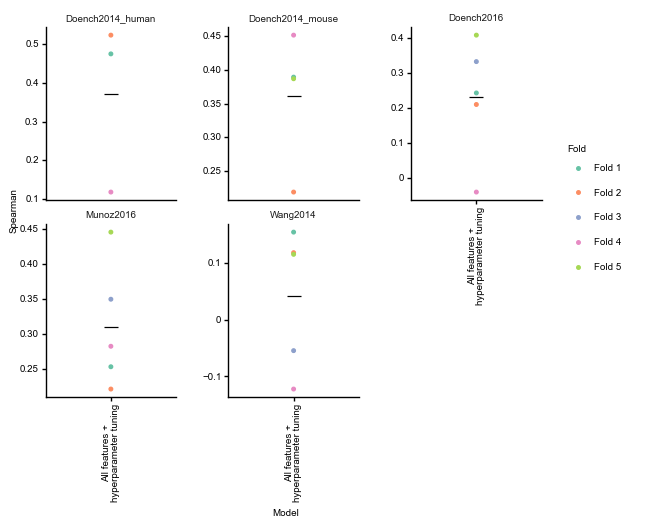

<ggplot: (8776935539577)>

In [45]:
g = plot_model_performance(tpe_predictive_performance, wspace=0.4)
g.save('../figures/target_model_tpe_performance.pdf', width=2.5, height=2.5)
g

### All Models

In [46]:
all_predictive_performance, all_agg_performance = get_predictive_performance(
    complete_feature_list + single_prediction_list + tpe_prediction_list + leave_one_prediction_list,
    'Residual Activity')
all_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All features +\nhyperparameter tuning,0.249248,0.177982,0.248490
1,All features,0.243202,0.146578,0.266182
2,No conservation,0.243106,0.129201,0.246775
3,No position,0.242326,0.160562,0.270829
4,No aa,0.220374,0.172575,0.202254
5,No domain,0.207319,0.160478,0.193439
6,domain,0.194020,0.174449,0.184055
7,aa,0.186075,0.147755,0.198058
8,conservation,0.109353,0.157461,0.124099
9,position,0.078879,0.078426,0.066053


In [47]:
training_group_dict = {'model_name': ['All features',
                                      'All features +\nhyperparameter tuning',
                                      'No conservation', 'No position',
                                      'No aa', 'No domain',
                                      'domain', 'aa',
                                      'conservation', 'position'],
                       'model_type': ['all']*2 +
                                     ['leave one out']*4 +
                                     ['single']*4}

all_performance_type_df = get_performance_type_df(training_group_dict, all_predictive_performance,
                                                  all_agg_performance)

Saving 2.5 x 3 in image.
Filename: ../figures/target_all_performance_heatmap.pdf


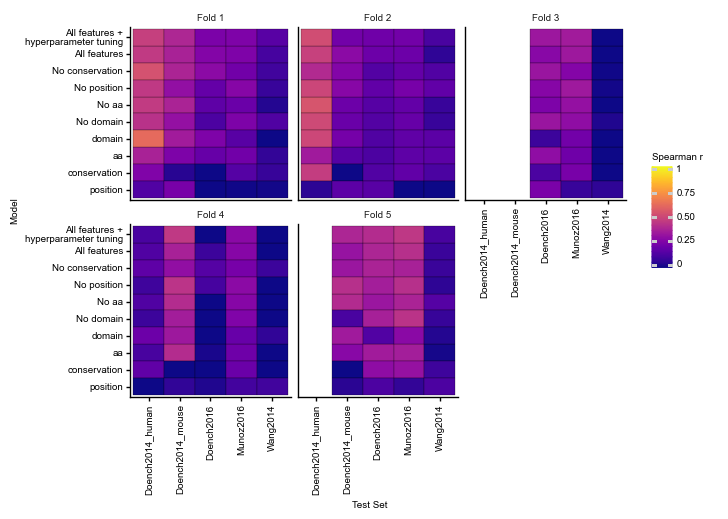

<ggplot: (8776691861968)>

In [48]:
g = plot_spearman_heatmap(all_predictive_performance)
g.save('../figures/target_all_performance_heatmap.pdf', width=2.5, height=3)
g

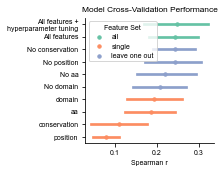

In [49]:
plot_performance_type_df(all_performance_type_df, 'Feature Set')
gpplot.savefig('../figures/target_cv_performance_pointplot.pdf')